In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc)

In [3]:
#Loading data
try:
    df = pd.read_csv("processed_stroke_dataset.csv")
except FileNotFoundError:
    print("Error: processed_stroke_dataset.csv not found. Please upload the file to Colab.")
    exit()

In [4]:
#Defining target and features
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

In [5]:
#Common Train-Test split (20% test, stratified to handle class imbalance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print("-" * 50)

Training set size: 12000 samples
Testing set size: 3000 samples
--------------------------------------------------


In [6]:
#Hyperparameter Tuning (GridSearchCV)
dtc = DecisionTreeClassifier(random_state=42)

#Define the grid of parameters to search
param_grid = {
    'max_depth': [5, 10, 15],  #Control overfitting by limiting depth
    'criterion': ['gini', 'entropy'] #Impurity measure
}

#Initializing GridSearchCV (optimizing for F1 Score with 5-fold CV)
grid_search = GridSearchCV(
    estimator=dtc,
    param_grid=param_grid,
    scoring='f1',
    cv=5, # 5-fold cross-validation
    n_jobs=-1,
    verbose=1
)

print("Starting GridSearchCV for Decision Tree...")
grid_search.fit(X_train, y_train)

Starting GridSearchCV for Decision Tree...
Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [5, 10, 15]},
             scoring='f1', verbose=1)

In [14]:
#Dispalying grid search tuning results
cv_df = pd.DataFrame(grid_search.cv_results_)
cols = ["param_max_depth","param_criterion","mean_test_score","std_test_score","rank_test_score"]
display(cv_df[cols].sort_values("rank_test_score"))

,param_max_depth,param_criterion,mean_test_score,std_test_score,rank_test_score
3,5,entropy,0.545643,0.079170,1
1,10,gini,0.497484,0.025505,2
4,10,entropy,0.490311,0.041470,3
2,15,gini,0.489468,0.016999,4
5,15,entropy,0.489445,0.019544,5
0,5,gini,0.475717,0.087144,6


In [7]:
#Getting the best model and its parameters/score
best_dtc = grid_search.best_estimator_
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("-" * 50)
print(f"Best parameters found by GridSearchCV: {best_params}")
print(f"Best cross-validation F1 score: {best_f1_score:.4f}")
print("-" * 50)

--------------------------------------------------
Best parameters found by GridSearchCV: {'criterion': 'entropy', 'max_depth': 5}
Best cross-validation F1 score: 0.5456
--------------------------------------------------


In [8]:
#Evaluating the Best Model on the test set
print("Evaluating the best model on the test set: ")
y_pred = best_dtc.predict(X_test)

#Calculating evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, best_dtc.predict_proba(X_test)[:, 1])   #ROC AUC requires probabilities

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set Recall: {recall:.4f}")
print(f"Test Set F1 Score: {f1:.4f}")
print(f"Test Set ROC AUC: {roc_auc:.4f}")
print("-" * 50)

Evaluating the best model on the test set: 
Test Set Accuracy: 0.4850
Test Set Precision: 0.4761
Test Set Recall: 0.3400
Test Set F1 Score: 0.3967
Test Set ROC AUC: 0.4779
--------------------------------------------------


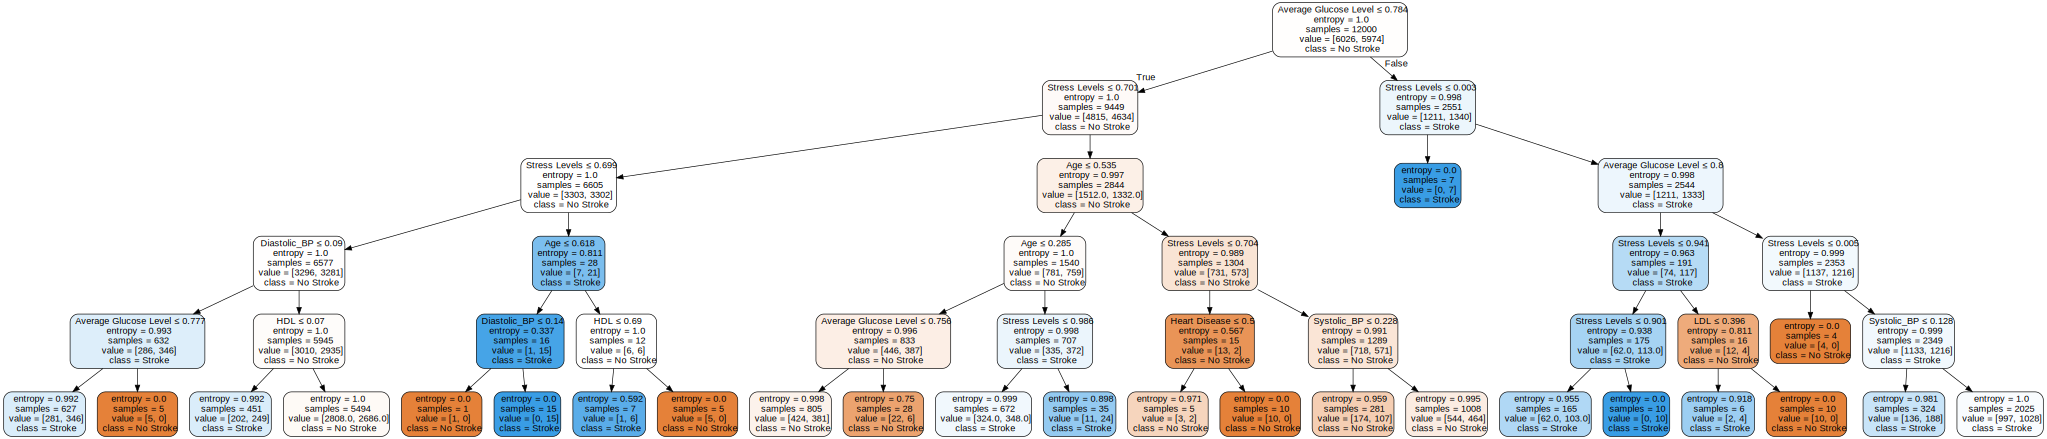

In [11]:
#Visualizing the Decision Tree
#Visualizing large trees can be difficult to interpret without graphviz.
from sklearn.tree import export_graphviz
import graphviz

try:
     dot_data = export_graphviz(
         best_dtc,
         out_file=None,
         feature_names=X.columns,
         class_names=['No Stroke', 'Stroke'],
         filled=True,
         rounded=True,
         special_characters=True
     )
     graph = graphviz.Source(dot_data)
     display(graph)
except ImportError:
     print("Graphviz not installed. Skipping tree visualization.")

Generating Confusion Matrix...


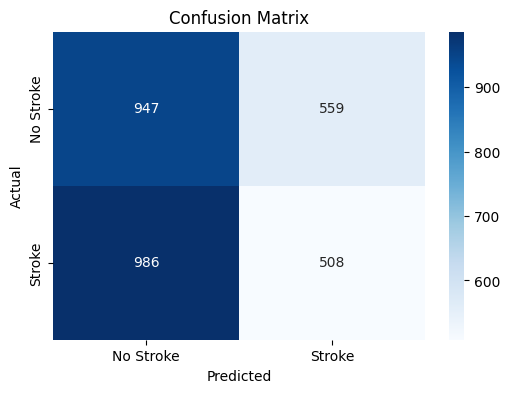

In [12]:
#Visualizing Confusion Matrix and ROC Curve
print("Generating Confusion Matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Stroke', 'Stroke'], yticklabels=['No Stroke', 'Stroke'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Generating ROC Curve...


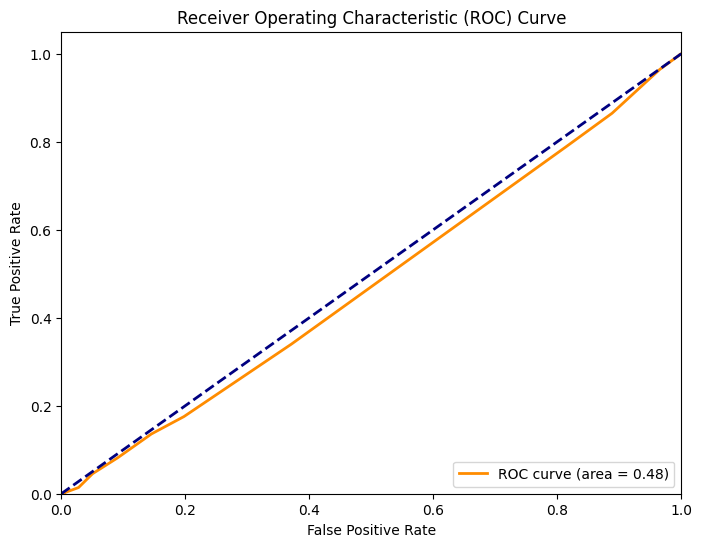

In [13]:
#Visualizing ROC Curve
print("Generating ROC Curve...")
fpr, tpr, thresholds = roc_curve(y_test, best_dtc.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()